In [2]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

from jax import jacfwd, jacrev
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [2]:
class Lorentz(eqx.Module):
    def __call__(self, t, y, args):
        sigma,rho,beta=args[0],args[1],args[2]

        f0 = sigma*(y[1]-y[0])
        f1 = y[0]*(rho-y[2])-y[1]
        f2 = y[0]*y[1]-beta*y[2]
        return jnp.stack([f0, f1, f2])


Lor=Lorentz()
params=np.array([10.,28,8/3])
y0 = np.array([0., 1., 1.05])



In [3]:

f=lambda y0,params : Lor(0,y0,params)

J=jacfwd(f)
y0 = np.array([10., 12., 1.05])

params=np.array([10.,28,8/3])
print(J(y0,params))

#             print(J(params))

print(jnp.linalg.eigvals(J(y0,params)))



# terms=diffrax.ODETerm(Lor)
# t0 = 0.0
# t1 = 100.0
# ts=np.linspace(600,1200,100000)
# solver = diffrax.Kvaerno5()
# saveat=diffrax.SaveAt(ts=ts)
# stepsize_controller = diffrax.PIDController(rtol=1e-4, atol=1e-10)
# sol = diffrax.diffeqsolve(terms=terms,solver=solver,t0=0,t1=ts[-1],y0=y0,saveat=saveat,dt0=0.01,stepsize_controller=stepsize_controller,args=params,max_steps=100000)
# plt.plot(sol.ts,sol.ys)

[[-10.          10.           0.        ]
 [ 26.95        -1.         -10.        ]
 [ 12.          10.          -2.66666667]]
[-22.45445016+0.j           4.39389175+6.91750642j
   4.39389175-6.91750642j]


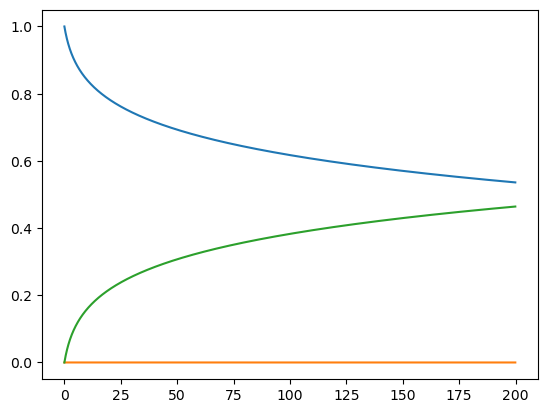

In [4]:
class Robertson(eqx.Module):
    k1: float
    k2: float
    k3: float

    def __call__(self, t, y, args):
        f0 = -self.k1 * y[0] + self.k3 * y[1] * y[2]
        f1 = self.k1 * y[0] - self.k2 * y[1] ** 2 - self.k3 * y[1] * y[2]
        f2 = self.k2 * y[1] ** 2
        return jnp.stack([f0, f1, f2])
    

@jax.jit
def main(k1, k2, k3):
    robertson = Robertson(k1, k2, k3)
    terms = diffrax.ODETerm(robertson)

    y0 = jnp.array([1.0, 0.0, 0.0])
    dt0 = 0.0002
    ts=jnp.arange(0,200,0.1)
    solver = diffrax.Kvaerno5()
    saveat = diffrax.SaveAt(ts=ts)
    stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
    sol = diffrax.diffeqsolve(
        terms,
        solver,
        ts[0],
        ts[-1],
        dt0,
        y0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
    )
    return sol


main(0.04, 3e7, 1e4)

start = time.time()
sol = main(0.04, 3e7, 1e4)
end = time.time()

plt.plot(sol.ts,sol.ys)

In [5]:
class Robertson(eqx.Module):


    def __call__(self, t, y, args):
        k1,k2,k3=args
        f0 = -k1 * y[0] + k3 * y[1] * y[2]
        f1 = k1 * y[0] - k2 * y[1] ** 2 - k3 * y[1] * y[2]
        f2 = k2 * y[1] ** 2
        return jnp.stack([f0, f1, f2])


robertson = Robertson()
f=lambda y0,params : robertson(0,y0,params)

params=[0.04, 3e7, 1e4]
J=jax.jit(jacfwd(f))

main(0.04, 3e7, 1e4)

start = time.time()
sol = main(0.04, 3e7, 1e4)
end = time.time()

params[0]=0.04
eigvals=[]
stiffness_ratio_1=[]
for i in range(len(sol.ts)):
    eigvals_t=jnp.linalg.eigvals(J(sol.ys[i,:],params))
    ratio=max(abs(eigvals_t.real))/min(abs(eigvals_t.real))
    stiffness_ratio_1.append(ratio)
    eigvals.append(eigvals_t)


main(0.08, 3e7, 1e4)

start = time.time()
sol = main(0.04, 3e7, 1e4)
end = time.time()

params[0]=12
eigvals=[]
stiffness_ratio_2=[]
for i in range(len(sol.ts)):
    eigvals_t=jnp.linalg.eigvals(J(sol.ys[i,:],params))
    ratio=max(abs(eigvals_t.real))/min(abs(eigvals_t.real))
    stiffness_ratio_2.append(ratio)
    eigvals.append(eigvals_t)


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

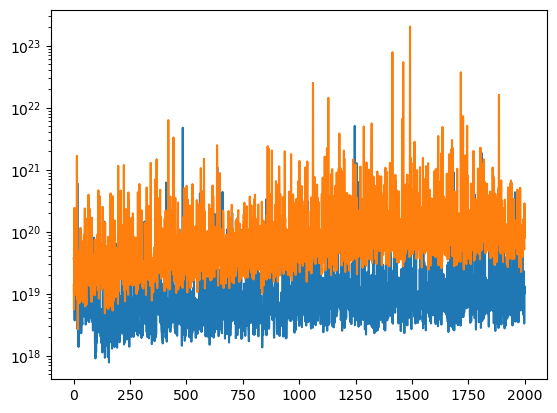

In [6]:


plt.plot(stiffness_ratio_1)
plt.plot(stiffness_ratio_2)
plt.yscale("log")


np.array(eigvals).imag==0
# eigvals.imag

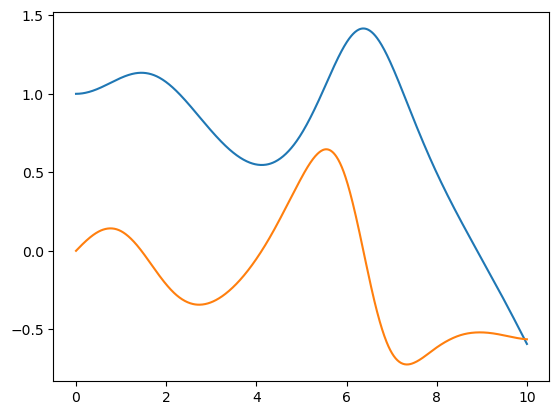

In [7]:
# Duffing oscillator parameters
delta = 0.2   # Damping coefficient
alpha = -1.0  # Linear stiffness
beta = 1.0    # Nonlinear stiffness
gamma = 0.3   # Amplitude of the driving force
omega = 1.2   # Frequency of the driving force


class time_dependency(diffrax.AbstractPath):
    @property
    def t0(self):
        return 0

    @property
    def t1(self):
        return 3

    def evaluate(self, t0, t1=None, left=True):
        del left
        if t1 is not None:
            return self.evaluate(t1) - self.evaluate(t0)
        return t0 



# Define the system of first-order ODEs
def duffing_oscillator(t, y,args):

    delta,alpha,beta,gamma,omega=args
    x=y[0]
    v = y[1]
    dxdt = v
    t=jnp.float64(t)
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * jnp.cos(omega*t)
    return jnp.stack([dxdt, dvdt])


params=[0.2,-1.0,1.0,0.3,1.2]
y0 = jnp.array([1.0, 0.0])


# control=time_dependency()
# control=diffrax.ControlTerm(duffing_oscillator,control).to_ode()
terms=diffrax.ODETerm(duffing_oscillator)


ts=jnp.linspace(0,10,1000)
solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-4, atol=1e-10)
sol = diffrax.diffeqsolve(terms=terms,solver=solver,t0=ts[0],t1=ts[-1],y0=y0,saveat=saveat,dt0=0.001,stepsize_controller=stepsize_controller,args=params,max_steps=1000)
plt.plot(sol.ts,sol.ys)

In [8]:


robertson = Robertson()
f=lambda t,y0,params : robertson(t,y0,params)

class duffing_oscillator():
    def __call__(self,t, y,params):
        delta=params['delta']
        alpha=params['alpha']
        omega=params['omega']
        beta=params['beta']
        gamma=params['gamma']
        # delta,alpha,beta,gamma,omega=params
        x=y[0]
        v = y[1]
        dxdt = v
        dvdt = -delta * v - alpha * x - beta * x**3 + gamma * jnp.cos(omega) #if we remove t, the jacobian evaluation exactly gives the qualitative dynamics around a reference point
        return jnp.stack([dxdt, dvdt])

duffing=duffing_oscillator()

params=[0.2,-1.0,1.0,0.3,1.2]
y0 = jnp.array([1.0, 0.0])






<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_295751/2686295693.py:32: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(sol.ts,sol.ys[:,1],label='$\lambda=-0.15+1.40j$')


(array([], dtype=int64), array([], dtype=int64))


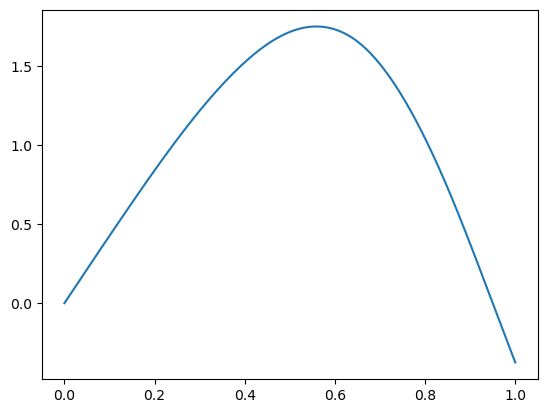

In [9]:
f=lambda y0,params : duffing(4,y0,params)


params={'delta':0,'alpha':-2.0,'beta':2.0,'gamma':3.3,'omega':6.2}
params={'delta':0,'alpha':-3.0,'beta':2.0,'gamma':3.3,'omega':6.2}

y0 = np.array([1.0, 0.0])
J=jacfwd(f)
J=jax.jit(J)
t=1.0


params_eigenvals=[]
for i in range(20):
    params['delta']=-i/20
    Jac=J(y0,params)
    eigvals=jnp.linalg.eigvals(Jac)
    params_eigenvals.append(eigvals)

np.where(np.array(params_eigenvals).real>0)
print(np.where(np.array(params_eigenvals).imag==0) and np.where(np.array(params_eigenvals).real<0))

params={'delta':0,'alpha':-3.0,'beta':2.0,'gamma':3.3,'omega':6.2}

duffing=duffing_oscillator()
terms=diffrax.ODETerm(duffing)
ts=jnp.linspace(0,1,1000)
solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-4, atol=1e-10)
sol = diffrax.diffeqsolve(terms=terms,solver=solver,t0=ts[0],t1=ts[-1],y0=y0,saveat=saveat,dt0=0.001,stepsize_controller=stepsize_controller,args=params,max_steps=100000)
plt.plot(sol.ts,sol.ys[:,1],label='$\lambda=-0.15+1.40j$')




In [10]:
jnp.linalg(J(y0,params))

TypeError: 'module' object is not callable

### Implement the jacobian for our kinetic models


16:22:15,621 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
16:22:15,622 - source.load_sbml.sbml_model - INFO - Model loaded.
16:22:15,623 - source.load_sbml.sbml_model - INFO -  number of species: 3
16:22:15,623 - source.load_sbml.sbml_model - INFO -  number of reactions: 2
16:22:15,623 - source.load_sbml.sbml_model - INFO -  number of global parameters: 36
16:22:15,624 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
16:22:15,624 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 2
16:22:15,624 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 5
16:22:15,665 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
16:22:15,665 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
16:22:15,666 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libt

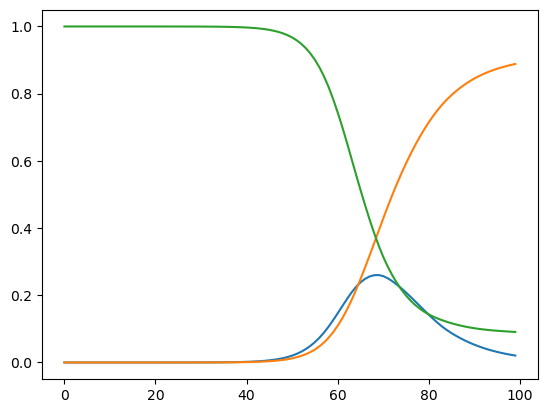

In [3]:
from source.load_sbml.sbml_load import *
from source.load_sbml.sbml_model import SBMLModel
import jax

filepath="models/sbml_models/working_models/Bertozzi2020.xml"
model=SBMLModel(filepath)
JaxKmodel = jax.jit(model.get_kinetic_model())

params = get_global_parameters(model.model)
params = {**model.local_params, **params}

# ts=ts[0]
ts=jnp.linspace(0,100,100)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)

# list(JaxKmodel.time_dict)
plt.plot(ys)

In [4]:

def make_jacobian(y0, params):
    global_params, local_params = separate_params(params)
    
    # Construct the global parameter dictionary
    global_params_dict = construct_param_point_dictionary(
        JaxKmodel.v_symbol_dictionaries,
        JaxKmodel.reaction_names,
        global_params
    )
    
    # Compute the function value
    y = JaxKmodel.func(t=0, y=y0, args=(global_params_dict, local_params, JaxKmodel.time_dict))
    return y

# Wrap the function to include parameters in a way that JAX can trace
def wrapped_make_jacobian(y0, global_params, local_params):
    params = {**global_params, **local_params}
    return make_jacobian(y0, params)

# Define the function for which the Jacobian is computed
f = lambda y0, global_params, local_params: wrapped_make_jacobian(y0, global_params, local_params)

# Compute the Jacobian
J = jacrev(f, argnums=0)

# JIT compile the Jacobian function
J_compiled = jax.jit(J)

# Example usage with initial parameters
y0 = model.y0
initial_global_params = {k: params[k] for k in params.keys()}  # Adjust as necessary
initial_local_params = {k: params[k] for k in model.local_params.keys()}    # Adjust as necessary

# Compute eigenvalues for the initial parameters
eigenvalues_initial = jnp.linalg.eigvals(J_compiled(y0, initial_global_params, initial_local_params))



In [13]:
jnp.linalg.eigvals(J_compiled(ys[-14,:],initial_global_params,initial_local_params))

Array([ 0.        +0.j       , -0.06362497+0.0121129j,
       -0.06362497-0.0121129j], dtype=complex128)

In [151]:
parameter_inits=pd.read_csv("parameter_initializations/initialization_succes/Fiedler_BMC2016/Fiedler_BMC2016_parameterset_id_lhs_N=1000run_1_log_update.csv",index_col=0)
epsilon=0.0001


my_eigenvalues=[]

indices_stable=[]
indices_oscillations=[]
for i in range(np.shape(parameter_inits)[0]):

    init_param=parameter_inits.iloc[i,:].to_dict()
    init_global_params, init_local_params = separate_params(init_param)
    eigenvalues_initial = jnp.linalg.eigvals(J_compiled(y0, init_global_params, init_local_params))
    #check if dynamics are stable
    stable_eigenvalues=eigenvalues_initial<(0+epsilon)
    if np.sum(stable_eigenvalues)==len(stable_eigenvalues):
        indices_stable.append(i)
    
    oscillations=eigenvalues_initial.imag>0
    if np.sum(oscillations)>1:
        indices_oscillations.append(i)






[ True False False  True  True  True]


3
4
9
12
14
19
21
26
27
28
29
34
40
41
47
49
51
53
57
60
62
64
66
68
71
72
73
83
97
98
99
101
104
111
112
115
118
121
124
128
130
132
134
135
137
139
140
142
143
144
147
150
158
159
166
175
177
180
187
193
194
195
197
205
206
207
209
212
214
215
219
221
222
223
228
232
233
234
239
241
244
245
250
251
255
256
257
259
261
267
268
269
270
272
273
274
275
277
278
279
280
281
283
287
289
294
295
300
301
304
309
310
316
317
319
324
326
335
337
342
346
349
352
353
358
361
366
371
372
373
376
380
387
389
390
394
396
397
403
404
405
408
409
410
413
414
416
417
418
419
421
422
432
433
435
436
440
441
446
447
451
455
456
457
461
463
464
465
469
471
477
482
484
485
490
492
494
501
502
503
504
509
510
513
515
518
521
524
526
531
532
536
538
539
543
546
549
550
551
552
554
555
556
558
562
563
566
570
572
577
579
590
592
595
601
604
605
607
610
611
612
614
617
618
622
624
627
630
631
632
636
639
641
644
648
652
653
654
656
657
661
663
664
666
673
674
676
680
685
686
687
688
695
699
701
705
707
708
71

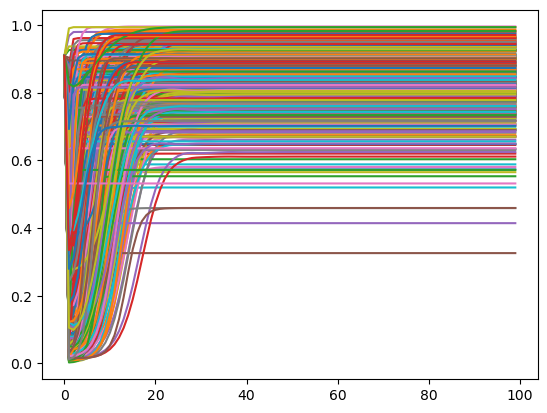

In [154]:
# for i in indices_stable:
#     print(i)
#     ys=JaxKmodel(ts=ts,y0=model.y0,params=parameter_inits.iloc[i,:].to_dict())
#     # plt.plot(ys[:,0])

for i in indices_stable:
    print(i)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=parameter_inits.iloc[i,:].to_dict())
    plt.plot(ys[0:100,4])
